In [300]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pd_support import read_df_csv
import scipy
from scipy.spatial.transform import Rotation as R

In [301]:
cart_df = pd.read_csv("..//straight_line.csv")

In [302]:
cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl
0,2022-06-14 15:03:48.326735,1,0,0,0
1,2022-06-14 15:03:48.546016,1,0,0,0
2,2022-06-14 15:03:48.546516,1,0,0,0
3,2022-06-14 15:03:48.546516,1,0,0,0
4,2022-06-14 15:03:48.546516,1,0,0,0
...,...,...,...,...,...
3561,2022-06-14 15:04:19.857543,3824,4045,3841,3901
3562,2022-06-14 15:04:19.858041,3824,4045,3841,3901
3563,2022-06-14 15:04:19.938882,3824,4045,3841,3901
3564,2022-06-14 15:04:19.939315,3824,4045,3841,3901


In [303]:
mc, mc_dt = read_df_csv("..//linear_forward_mc.csv")
mc_dt

datetime.datetime(2022, 6, 14, 15, 3, 52, 98000)

In [304]:
type(mc["center_y"][0])

numpy.float64

In [305]:
mc = mc.rename(columns={"time":"seconds"})

In [306]:
_t = []
for i in list(mc["seconds"]):
    _t.append(mc_dt + timedelta(0,float(i)))

mc["time"] = _t

In [307]:
mc

,frame,seconds,center_x,center_y,center_z,org_x,org_y,org_z,xdir_x,xdir_y,xdir_z,zdir_x,zdir_y,zdir_z,time
0,0,0.00,0.045857,0.068821,-0.081540,0.003887,0.069184,-0.146124,0.083270,0.066830,-0.146643,0.005686,0.069255,-0.018596,2022-06-14 15:03:52.098
1,1,0.01,0.045868,0.068813,-0.081547,0.003862,0.069154,-0.146151,0.083285,0.066831,-0.146648,0.005683,0.069261,-0.018592,2022-06-14 15:03:52.108
2,2,0.02,0.045856,0.068817,-0.081544,0.003880,0.069194,-0.146121,0.083275,0.066833,-0.146650,0.005672,0.069261,-0.018588,2022-06-14 15:03:52.118
3,3,0.03,0.045849,0.068824,-0.081547,0.003879,0.069186,-0.146123,0.083275,0.066815,-0.146652,0.005674,0.069258,-0.018586,2022-06-14 15:03:52.128
4,4,0.04,0.045851,0.068822,-0.081540,0.003875,0.069197,-0.146128,0.083278,0.066837,-0.146640,0.005688,0.069259,-0.018586,2022-06-14 15:03:52.138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,2570,25.70,0.054029,0.068274,0.209136,0.009873,0.068308,0.145931,0.089050,0.066059,0.143031,0.016038,0.068579,0.273257,2022-06-14 15:04:17.798
2571,2571,25.71,0.054021,0.068267,0.209126,0.009868,0.068302,0.145933,0.089045,0.066047,0.143030,0.016037,0.068582,0.273258,2022-06-14 15:04:17.808
2572,2572,25.72,0.054045,0.068269,0.209130,0.009867,0.068299,0.145933,0.089044,0.066053,0.143029,0.016028,0.068604,0.273261,2022-06-14 15:04:17.818
2573,2573,25.73,0.054040,0.068284,0.209123,0.009869,0.068299,0.145941,0.089042,0.066056,0.143031,0.016038,0.068585,0.273253,2022-06-14 15:04:17.828


In [308]:
mc["time"] = pd.to_datetime(mc["time"])

In [309]:
"""getting initial values of motion capture data"""

marker_cen = np.array(mc[["center_x", "center_y", "center_z"]].iloc[0]).T
marker_xvec = np.array(mc[["xdir_x", "xdir_y", "xdir_z"]].iloc[0]).T
marker_zvec = np.array(mc[["zdir_x", "zdir_y", "zdir_z"]].iloc[0]).T
marker_org = np.array(mc[["org_x", "org_y", "org_z"]].iloc[0]).T
marker_org[0]

0.003887

In [310]:
v1 = marker_xvec - marker_org #v1
v2 = marker_zvec - marker_org #v2

v1 = v1.reshape(3,1)
v2 = v2.reshape(3,1)
v3 = marker_org.reshape(3,1)

In [311]:
def calculate_rotmat(xdir,zdir,org):
    """
    this function calculates rotation matrix
    """
    v1 = xdir - org #v1
    v2 = zdir - org #v2

    vxnorm = v1/np.linalg.norm(v1)

    vzcap = v2 - (vxnorm.T @ v2) * vxnorm
    vznorm = vzcap/ np.linalg.norm(vzcap)

    vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3,1)
    rotMat = np.hstack((vxnorm, vynorm, vznorm))
    return rotMat

In [312]:
"""getting initial rot mat in mc data"""

rot_mat = calculate_rotmat(v1, v2, v3)
rot_mat

array([[ 0.42191585,  0.40244823, -0.81241765],
       [-0.39979623,  0.8868394 ,  0.23168696],
       [ 0.81372599,  0.22704911,  0.53506888]])

In [313]:
temp_list = []
for i in range(len(mc["xdir_x"])):
    center_val =  np.array(mc[["center_x", "center_y", "center_z"]].iloc[i])
    center_val = center_val.reshape(3,1)
    transformed_center = rot_mat.T @ center_val + v3
    transformed_center = transformed_center.T[0]
    temp_list.append(transformed_center)
mc[["cen_x", "cen_y", "cen_z"]] = temp_list

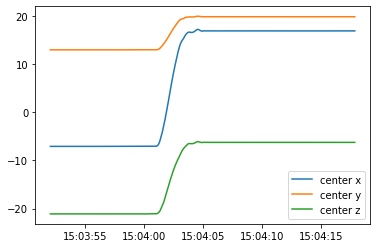

In [314]:
plt.plot(mc["time"], mc["cen_x"]*100, label="center x")
plt.plot(mc["time"], mc["cen_y"]*100, label="center y")
plt.plot(mc["time"], mc["cen_z"]*100, label="center z")
plt.legend()

In [315]:
"""resetting cart values to zero"""
cart_df["e_fr"] = cart_df["e_fr"]- cart_df["e_fr"].iloc[0]
cart_df["e_fl"] = cart_df["e_fl"]- cart_df["e_fl"].iloc[0]
cart_df["e_rr"] = cart_df["e_rr"]- cart_df["e_rr"].iloc[0]
cart_df["e_rl"] = cart_df["e_rl"]- cart_df["e_rl"].iloc[0]

cart_df

,sys_time,e_fr,e_fl,e_rr,e_rl
0,2022-06-14 15:03:48.326735,0,0,0,0
1,2022-06-14 15:03:48.546016,0,0,0,0
2,2022-06-14 15:03:48.546516,0,0,0,0
3,2022-06-14 15:03:48.546516,0,0,0,0
4,2022-06-14 15:03:48.546516,0,0,0,0
...,...,...,...,...,...
3561,2022-06-14 15:04:19.857543,3823,4045,3841,3901
3562,2022-06-14 15:04:19.858041,3823,4045,3841,3901
3563,2022-06-14 15:04:19.938882,3823,4045,3841,3901
3564,2022-06-14 15:04:19.939315,3823,4045,3841,3901


In [316]:
mils = np.arange(0, len(cart_df["e_fr"])*10, 10)
cart_df["mils"] = mils
cart_df["sys_time"] = pd.to_datetime(cart_df["sys_time"])

These are the parameters of the cart

Diameter = 95 mm
radius = 47.5
wheel thickness = 45 mm
gap between wheel and chassis = 6.5 mm
angle between center of chassis and z-dir vector = 51.21 degrees
distance between the wheel = 158 mm
distance between the wheel and the center of the robot = 101.36 (li)


In [317]:
"""circumfrence of the wheel"""

cir_wheel = np.degrees(2*np.pi*(47.5/1000))
cir_wheel
radius = 47.5/1000

lx = 79 #half of the distance between the wheels
ly = 122.5/2

lx = lx/1000
ly = ly/1000

The encoder values will give 4000 values per revolution
360/4000 = 0.09 degrees per encoder rotation value

In [318]:
""" angular velocity"""
cart_df["av_fr"] = (cart_df["e_fr"]*0.09).diff()/0.01
cart_df["av_fl"] = (cart_df["e_fl"]*0.09).diff()/0.01
cart_df["av_rr"] = (cart_df["e_rr"]*0.09).diff()/0.01
cart_df["av_rl"] = (cart_df["e_rl"]*0.09).diff()/0.01
cart_df['av_fr'] = cart_df["av_fr"].fillna(0)
cart_df['av_fl'] = cart_df["av_fl"].fillna(0)
cart_df['av_rr'] = cart_df["av_rr"].fillna(0)
cart_df['av_rl'] = cart_df["av_rl"].fillna(0)

#converting them to radians
cart_df['av_fr'] = cart_df["av_fr"]* np.pi/180
cart_df['av_fl'] = cart_df["av_fl"]* np.pi/180
cart_df['av_rr'] = cart_df["av_rr"]* np.pi/180
cart_df['av_rl'] = cart_df["av_rl"]* np.pi/180

cart_df["av_fl"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3561    0.0
3562    0.0
3563    0.0
3564    0.0
3565    0.0
Name: av_fl, Length: 3566, dtype: float64

In [319]:
g1 = np.radians(-51.21)
g2 = np.radians(51.21)

g1 = np.radians(-np.pi/2)
g2 = np.radians(np.pi/2)

g3 = g2
g4 = g1


b1 = np.pi/4
b2 = -np.pi/4
b3 = b1
b4 = b2


a1 = np.pi/4
a2 = -np.pi/4
a3 = 3*np.pi/4
a4 = -3*np.pi/4


li = 101.36/1000

In [320]:
t = (-1/radius)*np.array([[np.cos(b1 - g1)/ np.sin(g1), np.sin(b1 - g1)/np.sin(g1), li * np.sin(b1 - g1 - a1)/np.sin(g1)],
                         [np.cos(b2 - g2)/ np.sin(g2), np.sin(b2 - g2)/np.sin(g2), li * np.sin(b2 - g2 - a2)/np.sin(g2)],
                         [np.cos(b3 - g3)/ np.sin(g3), np.sin(b3 - g3)/np.sin(g3), li * np.sin(b3 - g3 - a3)/np.sin(g3)],
                         [np.cos(b4 - g4)/ np.sin(g4), np.sin(b4 - g4)/np.sin(g4), li * np.sin(b4 - g4 - a4)/np.sin(g4)]]
                         )
t
pseudo_t = np.linalg.pinv(t)
pseudo_t

array([[ 4.47561242e-04, -4.47561242e-04, -4.72799786e-04,
         4.72799786e-04],
       [ 8.73787444e-04,  8.73787444e-04, -2.39613824e-05,
        -2.39613824e-05],
       [ 5.92854944e-03,  5.92854944e-03,  6.26286783e-03,
         6.26286783e-03]])

In [321]:
val = pseudo_t @ np.array([[cart_df["av_fr"][0]],[cart_df["av_fl"][0]], [cart_df["av_rr"][0]], [cart_df["av_rl"][0]]])
val.T

array([[0., 0., 0.]])

In [322]:
np.array([[cart_df["av_fr"][0]],[cart_df["av_fl"][0]], [cart_df["av_rr"][0]], [cart_df["av_rl"][0]]])

array([[0.],
       [0.],
       [0.],
       [0.]])

In [323]:
_val = []
for i in range(len(cart_df["e_fl"])):
    _v = pseudo_t @ np.array([[cart_df["av_fr"][i]],[cart_df["av_fl"][i]], [cart_df["av_rr"][i]], [cart_df["av_rl"][i]]])
    _val.append(_v.T[0])

cart_df[["cal_vx", "cal_vy", "cal_w"]] = _val
# _val

In [324]:
"""finding vx, vy, w"""

cart_df["vx"] = (cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] + cart_df["av_rr"])*(radius/4)
cart_df["vy"] = (- cart_df["av_fl"] + cart_df["av_fr"] + cart_df["av_rl"] - cart_df["av_rr"])*(radius/4)
cart_df["w"] = (- cart_df["av_fl"] + cart_df["av_fr"] - cart_df["av_rl"] + cart_df["av_rr"])*(radius/(4*(lx + ly)))

In [325]:
"""calculating displacement
s=(1/2)* (v+u)t
v = current velocityn
u = initial velocity
t = time
s = displacement
"""

_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["vx"].iloc[i] + cart_df["vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["vy"].iloc[i] + cart_df["vy"].iloc[i-1])*0.01
        # print(x_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+yf_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["x_val"] = _xval
cart_df["y_val"] = _yval

In [326]:
"""calculating displacement for calculated coordinates

"""
_xval = []
_yval = []
xf_disp = 0
yf_disp = 0
for i in range(len(cart_df["vx"])):
    if i == 0:
        _xval.append(0)
        _yval.append(0)
    else:
        x_disp = 0.5*(cart_df["cal_vx"].iloc[i] + cart_df["cal_vx"].iloc[i-1])*0.01
        y_disp = 0.5*(cart_df["cal_vy"].iloc[i] + cart_df["cal_vy"].iloc[i-1])*0.01
        # print(x_disp)
        xf_disp = xf_disp+x_disp
        yf_disp = yf_disp+yf_disp
        _xval.append(xf_disp)
        _yval.append(yf_disp)

cart_df["cal_x"] = _xval
cart_df["cal_y"] = _yval


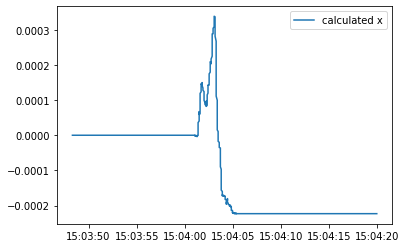

In [327]:
# plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "ideal x")
plt.plot(cart_df["sys_time"],cart_df["cal_x"], label = "calculated x")
# plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "idal x")
plt.legend()

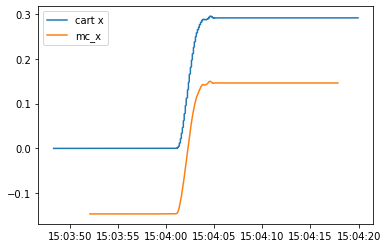

In [336]:
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "cart x")
plt.plot(mc["time"], mc["org_z"], label  = "mc_x")
plt.legend()

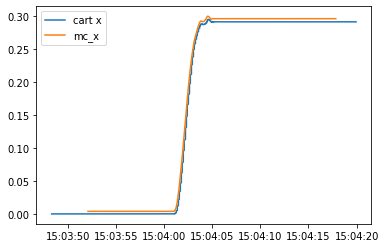

In [338]:
plt.plot(cart_df["sys_time"], cart_df["x_val"], label = "cart x")
plt.plot(mc["time"], mc["org_z"]+0.15, label  = "mc_x")
plt.legend()

In [330]:
rw = []
vr = []
for i in range(len(cart_df["av_rl"])):
    _vy = cart_df["cal_vy"][i]
    _vx = cart_df["cal_vx"][i]
    rw.append(np.arctan2(_vy, _vx))
    vr.append(np.linalg.norm((_vx, _vy)))
cart_df["rw"] = rw
cart_df["vr"] = vr

In [331]:
cart_df["rw"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3561    0.0
3562    0.0
3563    0.0
3564    0.0
3565    0.0
Name: rw, Length: 3566, dtype: float64

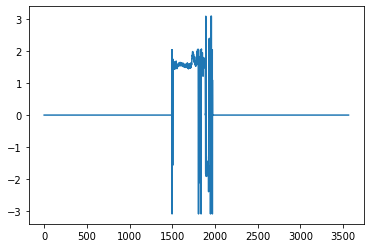

In [332]:
plt.plot(cart_df["rw"])

In [333]:
cart_df["rw"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3561    0.0
3562    0.0
3563    0.0
3564    0.0
3565    0.0
Name: rw, Length: 3566, dtype: float64